<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/CNNs/Deep%20Architectures/Template%20Cifar10%20Classification/Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Composite Transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

## Load Data

In [3]:
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = CIFAR10(root='./data', train=False, download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Validation Sampler

In [4]:
# percentage of training set to use as validation
valid_size = 0.2
# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [5]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

## DataLoader

In [6]:
batch_size = 20
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

## Classes in CIFAR10

In [7]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Batch Visulaization

In [8]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [9]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

print(images.shape)

print(images[1].shape)
print(labels[1].item())

(20, 3, 32, 32)
(3, 32, 32)
9


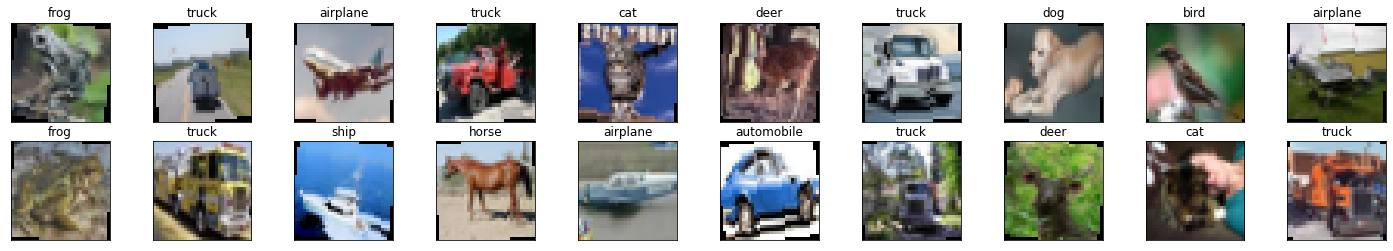

In [10]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Single Image Visualization

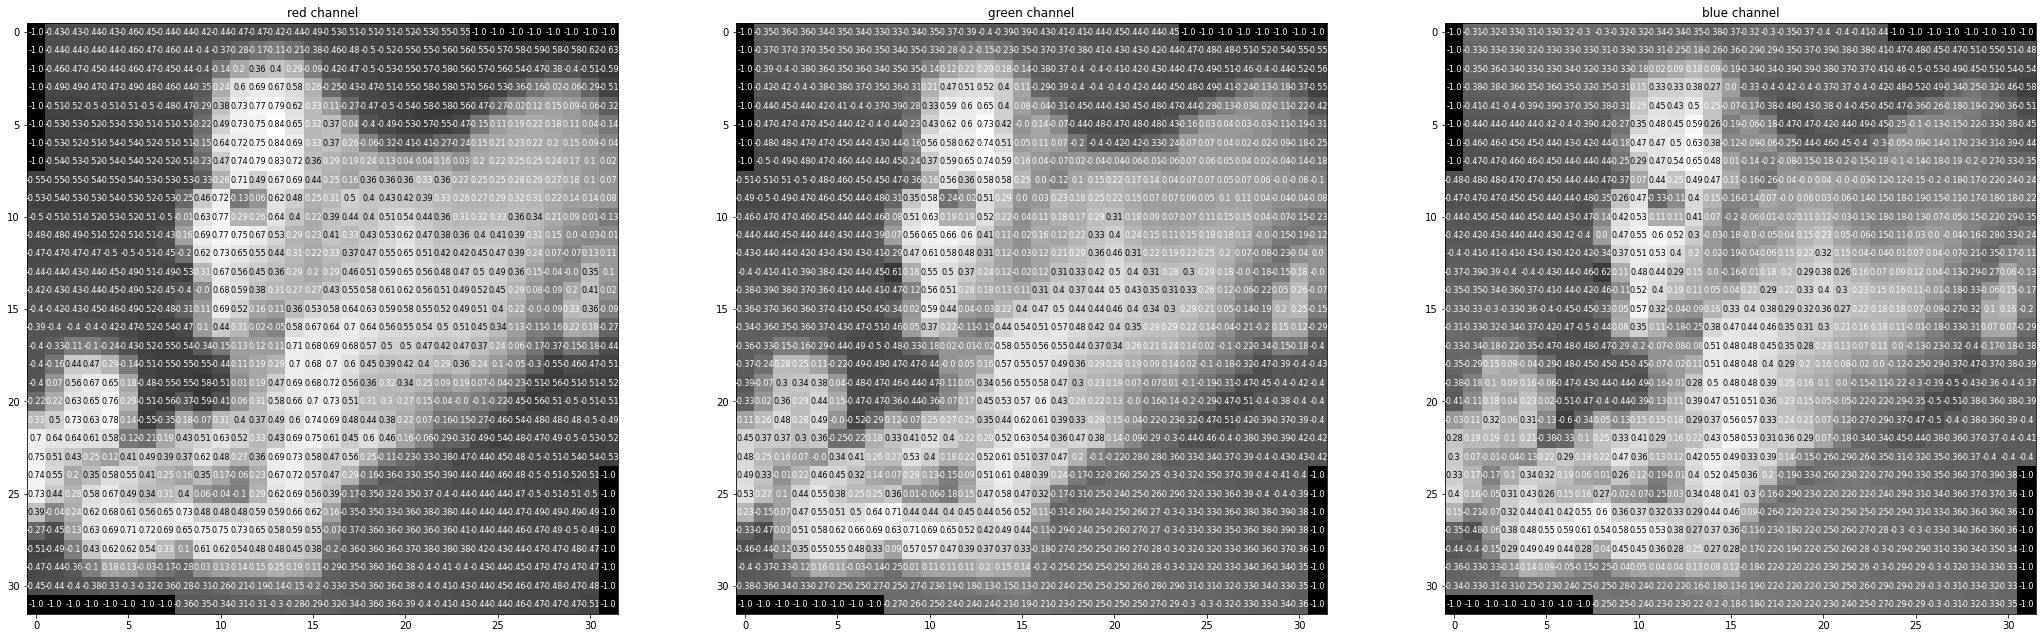

In [11]:
rgb_img = np.squeeze(images[7])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## GPU Configure

In [12]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')

1
Tesla P4


## CIFAR10 Model Class

In [13]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # convolutional layer (sees 16x16x16 tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # convolutional layer (sees 8x8x32 tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    # linear layer (64 * 4 * 4 -> 500)
    self.fc1 = nn.Linear(64 * 4 * 4, 500)
    # linear layer (500 -> 10)
    self.fc2 = nn.Linear(500, 10)
    # dropout layer (p=0.25)
    self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
    # add sequence of convolutional and max pooling layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # flatten image input
    x = x.view(-1, 64 * 4 * 4)
    # add dropout layer
    x = self.dropout(x)
    # add 1st hidden layer, with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add 2nd hidden layer, with relu activation function
    x = self.fc2(x)
    return x
  
  def evaluation(self,dataloader):
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(gpu), labels.to(gpu)
      outputs = self.forward(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
    return 100 * correct / total
  
  def fit(self,epochs,trainloader,validloader):
    valid_loss_min = np.Inf # track change in validation loss
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.SGD(self.parameters(), lr=0.05)
    
    for epoch in range(epochs):
      
      # keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ###################
      # train the model #
      ###################
      self.train()
      for i, data in enumerate(trainloader, 0): 
        inputs, labels = data
        inputs, labels = inputs.to(gpu), labels.to(gpu)
        
        #clears the gradients of all optimized variables
        opt.zero_grad() 
        
        # Forward Pass
        outputs = self.forward(inputs) 
        
        # compute Loss
        loss = loss_fn(outputs, labels) 
        
        #Compute gradient with respect to loss of weights 
        loss.backward() 
        
        # parameter updates
        opt.step()

        # update training loss
        train_loss += loss.item()*data[1].shape[0]
      
      ######################    
      # validate the model #
      ######################
      self.eval()
      for i, data in enumerate(validloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(gpu), labels.to(gpu)
        
        # Forward Pass
        outputs = self.forward(inputs) 

        # compute Loss
        loss = loss_fn(outputs, labels) 

        # update valid loss
        valid_loss += loss.item()*data[1].shape[0]

      # calculate average losses
      train_loss = train_loss/len(trainloader.sampler)
      valid_loss = valid_loss/len(validloader.sampler)
      
      #print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

In [15]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [16]:
model = model.to(gpu)
model.fit(50,trainloader,validloader)

Epoch: 0 	Training Loss: 1.752061 	Validation Loss: 1.513926
Validation loss decreased (inf --> 1.513926).  Saving model ...
Epoch: 1 	Training Loss: 1.359748 	Validation Loss: 1.171859
Validation loss decreased (1.513926 --> 1.171859).  Saving model ...
Epoch: 2 	Training Loss: 1.195320 	Validation Loss: 1.061542
Validation loss decreased (1.171859 --> 1.061542).  Saving model ...
Epoch: 3 	Training Loss: 1.095310 	Validation Loss: 0.981548
Validation loss decreased (1.061542 --> 0.981548).  Saving model ...
Epoch: 4 	Training Loss: 1.021881 	Validation Loss: 0.976052
Validation loss decreased (0.981548 --> 0.976052).  Saving model ...
Epoch: 5 	Training Loss: 0.969518 	Validation Loss: 0.906500
Validation loss decreased (0.976052 --> 0.906500).  Saving model ...
Epoch: 6 	Training Loss: 0.927274 	Validation Loss: 0.878165
Validation loss decreased (0.906500 --> 0.878165).  Saving model ...
Epoch: 7 	Training Loss: 0.894258 	Validation Loss: 0.823397
Validation loss decreased (0.87816

## Load the Model with the Lowest Validation Loss

In [17]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [18]:
model.eval()
print("Test accuracy is : ",model.evaluation(testloader))

Test accuracy is :  75.64


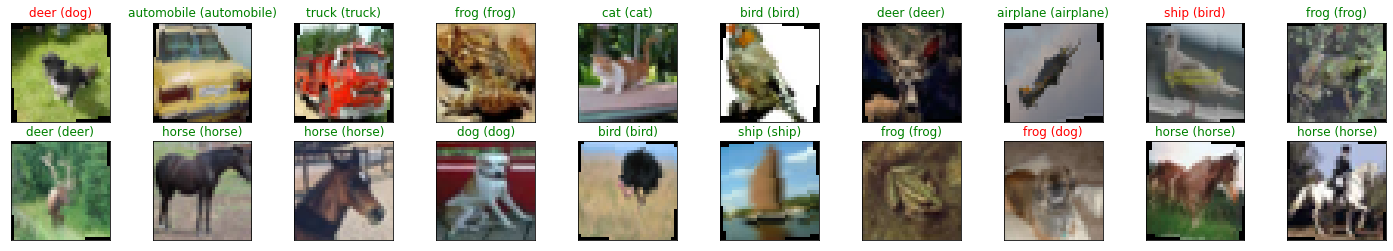

In [21]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(gpu)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))